## 特征工程
- 数据清洗: 移除缺失值、异常值和其他可能影响模型性能的数据。
- 标准化/归一化: 将数据缩放到相同范围 (例如：0 到 1) 可以提高模型的收敛速度和稳定性。
- 时间窗口划分: 将时间序列数据转换为监督学习问题，其中 X 是过去时间步的数据，Y 是未来时间步的预测值。

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
import numpy as np
from geopy.distance import geodesic
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
# from tensorflow.keras.models import Sequential
from keras.models import Model
from keras.utils import plot_model
# from tensorflow.keras.layers import Conv1D, GRU, Dense, Attention, Dropout, BatchNormalization, Input
from keras.layers import Input, Conv1D, BatchNormalization, GRU, Dropout, Dense, AdditiveAttention, LSTM
import matplotlib.pyplot as plt

### EDA


In [2]:
# 读取数据
data = pd.read_csv("./Data/JC-202403-citibike-tripdata.csv")

# 数据基本信息
data['started_at'] = pd.to_datetime(data['started_at'])
data['ended_at'] = pd.to_datetime(data['ended_at'])
data.describe()

,started_at,ended_at,start_lat,start_lng,end_lat,end_lng
count,65581,65581,65581.000000,65581.000000,65564.000000,65564.000000
mean,2024-03-16 14:16:38.480474624,2024-03-16 14:27:03.344855808,40.732531,-74.040144,40.732418,-74.039938
min,2024-03-01 00:01:39,2024-03-01 00:05:55,40.706529,-74.093255,40.670000,-74.120000
25%,2024-03-09 09:18:37,2024-03-09 09:26:40,40.721525,-74.045572,40.721525,-74.044247
50%,2024-03-16 09:02:54,2024-03-16 09:16:41,40.735767,-74.037682,40.735208,-74.037683
75%,2024-03-23 23:02:34,2024-03-23 23:31:52,40.742338,-74.031011,40.742258,-74.030970
max,2024-03-31 23:59:35,2024-04-01 01:16:36,40.754757,-74.023438,40.871390,-73.914318
std,NaN,NaN,0.012059,0.012066,0.012157,0.012094


### 特征构建

In [3]:
# 1.提取时间特征
data["date"] = data["started_at"].dt.date
data["weekday"] = data["started_at"].dt.weekday
data["month"] = data["started_at"].dt.month

data["start_day"] = data["started_at"].dt.day
data["start_hour"] = data["started_at"].dt.hour


data["end_day"] = data["ended_at"].dt.day
data["end_hour"] = data["ended_at"].dt.hour

# 判断是否为高峰时段 (例如：7-9 点和 17-19 点)


def is_peak_hour(hour):
    return (hour >= 7 and hour <= 9) or (hour >= 17 and hour <= 19)


data["is_peak_hour"] = data["start_hour"].apply(is_peak_hour)

# 2.提取用户特征
data["member_casual"] = data["member_casual"].map({"member": 1, "casual": 0})

# 计算骑行持续时间 (分钟)
data["trip_duration_minutes"] = (data["ended_at"] - data["started_at"]).dt.total_seconds() / 60


# 计算骑行直线距离

data = data.dropna(subset=['start_lat', 'start_lng', 'end_lat', 'end_lng'])


def calculate_distance(start_lat, start_lng, end_lat, end_lng):
    start_coords = (start_lat, start_lng)
    end_coords = (end_lat, end_lng)
    return geodesic(start_coords, end_coords).km


data["distance"] = data.apply(lambda row: calculate_distance(row["start_lat"], row["start_lng"], row["end_lat"], row["end_lng"]), axis=1)


# 3. 站点特征

# 统计每小时的骑行次数
data['start_count'] = data.groupby(['start_day', 'start_hour'])['ride_id'].transform('count')
data['end_count'] = data.groupby(['end_day', 'end_hour'])['ride_id'].transform('count')

data['site_start_count'] = data.groupby(['start_day', 'start_hour', 'start_station_id'])['ride_id'].transform('count')
data['site_end_count'] = data.groupby(['end_day', 'end_hour', 'end_station_id'])['ride_id'].transform('count')

# 统计每个站点的骑行次数
station_counts = data["start_station_id"].value_counts().to_dict()
data["start_station_popularity"] = data["start_station_id"].map(station_counts)


data

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,end_day,end_hour,is_peak_hour,trip_duration_minutes,distance,start_count,end_count,site_start_count,site_end_count,start_station_popularity
0,9F5EEFB7CF78C6EA,electric_bike,2024-03-21 13:32:42,2024-03-21 13:35:42,Stevens - River Ter & 6 St,HB602,City Hall - Washington St & 1 St,HB105,40.743143,-74.026907,...,21,13,False,3.000000,0.728135,97,90,5.0,3.0,893.0
1,01E2E1F218F9D303,electric_bike,2024-03-16 08:26:15,2024-03-16 08:47:53,Pershing Field,JC024,Pershing Field,JC024,40.742379,-74.051996,...,16,8,True,21.633333,0.037502,71,61,1.0,1.0,421.0
2,C2914D662B33AA55,electric_bike,2024-03-15 15:17:36,2024-03-15 15:32:12,Pershing Field,JC024,Pershing Field,JC024,40.742480,-74.051942,...,15,15,False,14.600000,0.025412,195,203,4.0,1.0,421.0
3,6723F7CE51888493,electric_bike,2024-03-13 08:34:26,2024-03-13 08:50:08,Pershing Field,JC024,Pershing Field,JC024,40.742400,-74.051963,...,13,8,True,15.700000,0.034075,262,275,4.0,1.0,421.0
4,EAB7E29AAB546941,electric_bike,2024-03-15 15:37:58,2024-03-15 16:19:32,Pershing Field,JC024,Pershing Field,JC024,40.742459,-74.051973,...,15,16,False,41.566667,0.028820,195,220,4.0,2.0,421.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65576,71034305DEC4E3AB,classic_bike,2024-03-27 17:40:07,2024-03-27 17:47:49,Grove St PATH,JC115,Lafayette Park,JC078,40.719410,-74.043090,...,27,17,True,7.700000,1.796117,210,207,27.0,3.0,3090.0
65577,52BD7EF18DBD0557,classic_bike,2024-03-15 17:25:05,2024-03-15 17:33:03,Grove St PATH,JC115,Lafayette Park,JC078,40.719410,-74.043090,...,15,17,True,7.966667,1.796117,356,326,14.0,2.0,3090.0
65578,376A4B66DD546551,classic_bike,2024-03-14 22:42:14,2024-03-14 22:50:17,Grove St PATH,JC115,Lafayette Park,JC078,40.719410,-74.043090,...,14,22,False,8.050000,1.796117,70,77,4.0,1.0,3090.0
65579,63F3690F5A7D58D4,classic_bike,2024-03-08 16:47:01,2024-03-08 16:56:44,Grove St PATH,JC115,Lafayette Park,JC078,40.719410,-74.043090,...,8,16,False,9.716667,1.796117,220,202,16.0,4.0,3090.0


In [4]:
data_onehot = pd.get_dummies(data, columns=["rideable_type", "start_station_id"], prefix="dummy_start")
data_onehot = pd.get_dummies(data_onehot, columns=["end_station_id"], prefix="dummy_end")
data_onehot = data_onehot.drop(columns=["end_station_name", "start_station_name", 'started_at', 'ended_at', 'ride_id'])
data_onehot

,start_lat,start_lng,end_lat,end_lng,member_casual,date,weekday,month,start_day,start_hour,...,dummy_end_JC102,dummy_end_JC103,dummy_end_JC104,dummy_end_JC105,dummy_end_JC107,dummy_end_JC108,dummy_end_JC109,dummy_end_JC110,dummy_end_JC115,dummy_end_JC116
0,40.743143,-74.026907,40.737360,-74.030970,1,2024-03-21,3,3,21,13,...,False,False,False,False,False,False,False,False,False,False
1,40.742379,-74.051996,40.742677,-74.051789,1,2024-03-16,5,3,16,8,...,False,False,False,False,False,False,False,False,False,False
2,40.742480,-74.051942,40.742677,-74.051789,1,2024-03-15,4,3,15,15,...,False,False,False,False,False,False,False,False,False,False
3,40.742400,-74.051963,40.742677,-74.051789,1,2024-03-13,2,3,13,8,...,False,False,False,False,False,False,False,False,False,False
4,40.742459,-74.051973,40.742677,-74.051789,1,2024-03-15,4,3,15,15,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65576,40.719410,-74.043090,40.713464,-74.062859,1,2024-03-27,2,3,27,17,...,False,False,False,False,False,False,False,False,False,False
65577,40.719410,-74.043090,40.713464,-74.062859,1,2024-03-15,4,3,15,17,...,False,False,False,False,False,False,False,False,False,False
65578,40.719410,-74.043090,40.713464,-74.062859,1,2024-03-14,3,3,14,22,...,False,False,False,False,False,False,False,False,False,False
65579,40.719410,-74.043090,40.713464,-74.062859,1,2024-03-08,4,3,8,16,...,False,False,False,False,False,False,False,False,False,False


In [5]:
non_dummy_cols = [col for col in data_onehot.columns if not col.startswith('dummy')]
non_dummy_cols.remove('date')
non_dummy_cols.remove('start_hour')
dummy_cols = [col for col in data_onehot.columns if col.startswith('dummy')]
len(dummy_cols), len(non_dummy_cols)

(230, 18)

In [6]:
mean_result = data_onehot.groupby(['date', 'start_hour'])[non_dummy_cols].mean()
count_result = data_onehot.groupby(['date', 'start_hour'])[dummy_cols].sum()
result = pd.concat([mean_result, count_result], axis=1).reset_index()
result = result.sort_values(['date', 'start_hour'], ascending=[True, True])
result

,date,start_hour,start_lat,start_lng,end_lat,end_lng,member_casual,weekday,month,start_day,...,dummy_end_JC102,dummy_end_JC103,dummy_end_JC104,dummy_end_JC105,dummy_end_JC107,dummy_end_JC108,dummy_end_JC109,dummy_end_JC110,dummy_end_JC115,dummy_end_JC116
0,2024-03-01,0,40.735228,-74.037922,40.741772,-74.044488,0.583333,4.0,3.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,2024-03-01,1,40.727577,-74.046939,40.730668,-74.046766,0.600000,4.0,3.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,2024-03-01,2,40.731491,-74.049671,40.725450,-74.060485,1.000000,4.0,3.0,1.0,...,0,1,0,0,0,0,0,0,0,0
3,2024-03-01,3,40.729665,-74.037371,40.735166,-74.039737,0.800000,4.0,3.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,2024-03-01,4,40.729661,-74.045348,40.729835,-74.046155,0.727273,4.0,3.0,1.0,...,0,1,0,0,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,2024-03-31,19,40.729850,-74.038985,40.731644,-74.041233,0.575000,6.0,3.0,31.0,...,2,1,1,7,0,0,2,3,8,1
737,2024-03-31,20,40.731417,-74.040935,40.729776,-74.044789,0.719101,6.0,3.0,31.0,...,0,1,2,4,0,0,2,0,6,1
738,2024-03-31,21,40.732426,-74.039611,40.732093,-74.040753,0.622222,6.0,3.0,31.0,...,0,0,1,0,0,0,0,1,1,0
739,2024-03-31,22,40.728027,-74.043429,40.729076,-74.046308,0.780488,6.0,3.0,31.0,...,1,0,1,0,0,0,0,2,0,0


In [7]:
# 创建一个包含所有小时的完整日期时间范围
min_date = result['date'].min()
max_date = result['date'].max()+pd.Timedelta(days=1)
date_range = pd.date_range(min_date, max_date, freq='h')[:-1]  # 删除最后一行


# 创建一个包含所有日期时间的 DataFrame
full_result = pd.DataFrame({'date': date_range})
full_result['start_hour'] = full_result['date'].dt.hour
full_result['date'] = full_result['date'].dt.date

# 将原始数据 result 合并到完整的日期时间范围中，并将缺失的数据填充为 0
full_result = pd.merge(full_result, result, how='left', on=['date', 'start_hour'])
full_result = full_result.fillna(0).set_index('date')

# 重新排序列
cols = ['start_count'] + [col for col in full_result.columns if col != 'start_count']
full_result = full_result.reindex(columns=cols)

full_result

,start_count,start_hour,start_lat,start_lng,end_lat,end_lng,member_casual,weekday,month,start_day,...,dummy_end_JC102,dummy_end_JC103,dummy_end_JC104,dummy_end_JC105,dummy_end_JC107,dummy_end_JC108,dummy_end_JC109,dummy_end_JC110,dummy_end_JC115,dummy_end_JC116
date,,,,,,,,,,,,,,,,,,,,,
2024-03-01,12.0,0,40.735228,-74.037922,40.741772,-74.044488,0.583333,4.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-03-01,10.0,1,40.727577,-74.046939,40.730668,-74.046766,0.600000,4.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-03-01,4.0,2,40.731491,-74.049671,40.725450,-74.060485,1.000000,4.0,3.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-03-01,5.0,3,40.729665,-74.037371,40.735166,-74.039737,0.800000,4.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-03-01,11.0,4,40.729661,-74.045348,40.729835,-74.046155,0.727273,4.0,3.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31,120.0,19,40.729850,-74.038985,40.731644,-74.041233,0.575000,6.0,3.0,31.0,...,2.0,1.0,1.0,7.0,0.0,0.0,2.0,3.0,8.0,1.0
2024-03-31,89.0,20,40.731417,-74.040935,40.729776,-74.044789,0.719101,6.0,3.0,31.0,...,0.0,1.0,2.0,4.0,0.0,0.0,2.0,0.0,6.0,1.0
2024-03-31,45.0,21,40.732426,-74.039611,40.732093,-74.040753,0.622222,6.0,3.0,31.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [8]:
array_full_result = np.array(full_result)
array_full_result.shape

(744, 249)

### 特征筛选

In [9]:

# # 选择与骑行次数最相关的特征
# # X = data[["hour", "weekday", "month", "is_weekend", "member_casual", "trip_duration"]]  # 选择特征
# # y = data.groupby(["started_at"]).size()  # 骑行次数

# # selector = SelectKBest(f_regression, k=4)  # 选择 4 个特征
# # X_selected = selector.fit_transform(X, y)

# # # 获取选择的特征名称
# # selected_features = X.columns[selector.get_support()]


# 标准化
scaler = StandardScaler()
result_standardized = scaler.fit_transform(array_full_result)

# 归一化
scaler = MinMaxScaler()
result_normalized = scaler.fit_transform(result_standardized)

# 存储标签
X = result_normalized[:, 1:]
Y = result_normalized[:, 0].reshape(-1, 1)


X.shape, Y.shape

((744, 248), (744, 1))

### 时间步长

In [10]:
# 将X,Y处理成三维数组，其中时间步长是24
x_result_normalized_3d = np.reshape(X, (-1, 24, X.shape[1]))
y_result_3d = np.reshape(Y, (-1, 24,  Y.shape[1]))
x_result_normalized_3d.shape, y_result_3d.shape

((31, 24, 248), (31, 24, 1))

### 划分数据集

In [11]:
# 划分训练集和测试集
X_train_temp, X_test, Y_train_temp, Y_test = train_test_split(x_result_normalized_3d, y_result_3d, test_size=0.2, random_state=42)

# 再将训练集划分为训练集和验证集
X_train, X_val, Y_train, Y_val = train_test_split(X_train_temp, Y_train_temp, test_size=0.25, random_state=42)  # 这里将剩余的80%划分为训练集和验证集，即训练集占64%，验证集占16%

In [12]:
X_train.shape, Y_train.shape

((18, 24, 248), (18, 24, 1))

In [13]:
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)

X_train shape: (18, 24, 248)
Y_train shape: (18, 24, 1)
X_val shape: (6, 24, 248)
Y_val shape: (6, 24, 1)


## 模型构建

### 模型I-CNN-LSTM-GRU-Attention

In [14]:
# 输入层
input_layer = Input(shape=(None, 248))

# 创建 CNN 层，注意添加 padding='same'
conv1d_layer_1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
batch_norm_1 = BatchNormalization()(conv1d_layer_1)
conv1d_layer_2 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(batch_norm_1)
batch_norm_2 = BatchNormalization()(conv1d_layer_2)

# 创建 GRU 层
gru_layer_1 = GRU(units=64, return_sequences=True)(batch_norm_2)
dropout_1 = Dropout(0.2)(gru_layer_1)
gru_layer_2 = GRU(units=64, return_sequences=True)(dropout_1)

# 添加注意力机制
attention_layer = AdditiveAttention()
attention_output = attention_layer([gru_layer_2, gru_layer_2])

# 添加输出层
output_layer = Dense(units=1)(attention_output)  # 输出层保持不变

# 创建模型
model_1 = Model(inputs=input_layer, outputs=output_layer)

# 编译模型
model_1.compile(loss='mse', optimizer='adam')
model_1.summary()

2024-04-28 20:18:44.321929: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-04-28 20:18:44.321948: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-04-28 20:18:44.321953: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-04-28 20:18:44.321968: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-28 20:18:44.321980: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None, 248) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, None, 64)  │     47,680 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, None, 64)  │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, None, 64)  │     12,352 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 64)  │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, None, 64)  │     24,960 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, None, 64)  │          0 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, None, 64)  │     24,960 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ additive_attention  │ (None, None, 64)  │         64 │ gru_1[0][0],      │
│ (AdditiveAttention) │                   │            │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None, 1)   │         65 │ additive_attenti… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 110,593 (432.00 KB)

 Trainable params: 110,337 (431.00 KB)

 Non-trainable params: 256 (1.00 KB)

In [15]:
# 训练模型并观察收敛情况
history_1 = model_1.fit(X_train, Y_train, epochs=100, batch_size=128, validation_data=(X_val, Y_val))

Epoch 1/100


2024-04-28 20:18:45.090900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1225 - val_loss: 0.0368
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0621 - val_loss: 0.0352
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0438 - val_loss: 0.0361
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0470 - val_loss: 0.0398
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0466 - val_loss: 0.0431
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0450 - val_loss: 0.0441
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0439 - val_loss: 0.0421
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0436 - val_loss: 0.0390
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0441 - val_loss: 0.0358
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0440 - val_loss: 0.0344
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0435 - val_loss: 0.0349
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0435 - val_loss: 0.0371
Epo

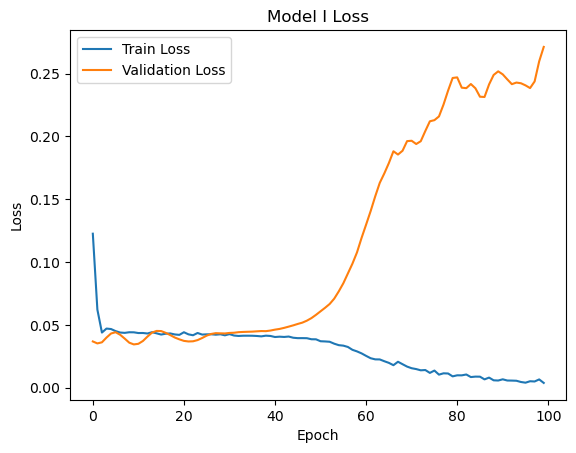

In [16]:
# 绘制训练和验证的损失图

plt.plot(history_1.history['loss'], label='Train Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Model I Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### 模型II-简单

In [17]:
# 输入层
input_layer = Input(shape=(None, 248))

# 创建单层 LSTM
lstm_layer = LSTM(units=32, return_sequences=True)(input_layer)

# 添加输出层
output_layer = Dense(units=1)(lstm_layer)  # 假设我们的目标是预测每个时间步的单个值

# 创建模型
model_2 = Model(inputs=input_layer, outputs=output_layer)

# 编译模型
model_2.compile(loss='mse', optimizer='adam')

# 打印模型摘要
model_2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, 248)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 32)       │        35,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 1)        │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,001 (140.63 KB)

 Trainable params: 36,001 (140.63 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# 训练模型并观察收敛情况
history_2 = model_2.fit(X_train, Y_train, epochs=100, batch_size=128, validation_data=(X_val, Y_val))

Epoch 1/100


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step - loss: 0.2409 - val_loss: 0.0571
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0874 - val_loss: 0.0464
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0502 - val_loss: 0.0823
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0807 - val_loss: 0.0997
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0992 - val_loss: 0.0891
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0888 - val_loss: 0.0658
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0651 - val_loss: 0.0434
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0431 - val_loss: 0.0287
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0301 - val_loss: 0.0227
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0270 - val_loss: 0.0227
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0299 - val_loss: 0.0246
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0338 - val_loss: 0.0254


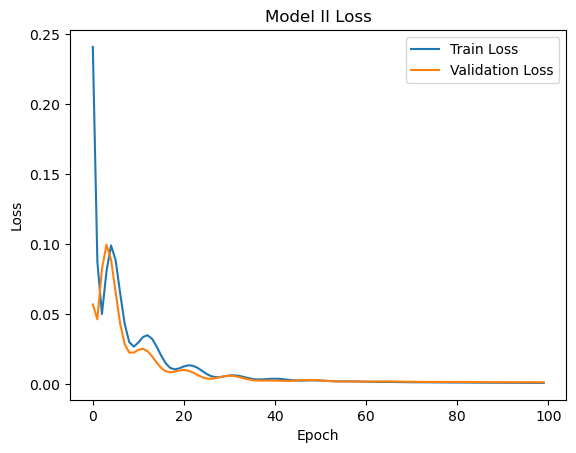

In [19]:
# 绘制训练和验证的损失图
plt.plot(history_2.history['loss'], label='Train Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Model II Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()